# Import needed modules

In [1]:
# System libraries
import os
import time
import shutil
import pathlib
import itertools

# Data Handling libraries
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# For ignoring the warnings
import warnings
warnings.filterwarnings("ignore")

#### **Function to create data frame**

In [2]:
def def_paths(dir):
    file_pths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)

        for fold_ in filelist:
            foldpath_ = os.path.join(foldpath, fold_)
            filelist_ = os.listdir(foldpath_)

            for file_ in filelist_:
                fpath = os.path.join(foldpath_, file_)
                file_pths.append(fpath)
                labels.append(fold_)

    return file_pths, labels


# join data paths
def define_df(files, classes):
    fser = pd.Series(files, name= 'file_pths')
    lser = pd.Series(classes, name='labels')
    return pd.concat([fser, lser], axis= 1)


# creating dataframe for training, testing and validation
def create_df(data_dirs):

    files, classes = def_paths(data_dirs)
    df = define_df(files, classes)
    
    strat = df['labels']
    training_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=123, stratify=strat)
   
    strat = dummy_df['labels']
    valid_df, test_df= train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

    return training_df, valid_df, test_df

#### Function to generate images from dataframe

In [3]:
def create_model_data(training_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    testing_length = len(test_df)
    test_batch_size = max(sorted([testing_length // n for n in range(1, testing_length + 1) if testing_length%n == 0 and testing_length/n <= 80]))
    test_steps = testing_length // test_batch_size

    def ret_img(img):
        return img

    training_gen = ImageDataGenerator(preprocessing_function= ret_img, horizontal_flip= True)
    testing_gen = ImageDataGenerator(preprocessing_function= ret_img)

    train_gen = training_gen.flow_from_dataframe( training_df, x_col= 'file_pths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = testing_gen.flow_from_dataframe( valid_df, x_col= 'file_pths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = testing_gen.flow_from_dataframe( test_df, x_col= 'file_pths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

#### **Function to display data sample**

In [4]:
def display_imgs(gen):

    g_dict = gen.class_indices       
    classes = list(g_dict.keys())
    images, labels = next(gen)        

    length = len(labels)
    sample = min(length, 25) 

    plt.figure(figsize= (25, 25))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255    
        plt.imshow(image)
        index = np.argmax(labels[i]) 
        class_name = classes[index] 
        plt.title(class_name, color= 'blue', fontsize= 15)
    plt.show()

#### **Function to plot value counts for a column in a dataframe**

In [5]:
def count_plot_labels(df, plot_title):
    vcounts = df['labels'].value_counts()
    labels = vcounts.keys().tolist()
    values = vcounts.tolist()
    lcount = len(labels)

    if lcount > 55:
        print('The number of labels is > 55, no plot will be produced')

    else:
        plot_labels(lcount, labels, values, plot_title)

def plot_labels(lcount, labels, values, plot_title):
    width = lcount * 4
    width = np.min([width, 20])

    plt.figure(figsize= (width, 5))

    form = {'family': 'serif', 'color': 'blue', 'size': 30}
    sns.barplot(labels, values)
    plt.title(f'Images per Label in {plot_title} data', fontsize= 25, color= 'blue')
    plt.xticks(rotation= 90, fontsize= 20)
    plt.yticks(fontsize= 20)
    plt.xlabel('CLASS', fontdict= form)
    yaxis_label = 'IMAGE COUNT'
    plt.ylabel(yaxis_label, fontdict= form)

    rotation = 'vertical' if lcount >= 8 else 'horizontal'
    for i in range(lcount):
        plt.text(i, values[i] / 2, str(values[i]), fontsize= 12,
                rotation= rotation, color= 'yellow', ha= 'center')

    plt.show()

#### **Callbacks** 

In [6]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

#### **Plot trained model**

In [7]:
def plot_training(hist):
    training_acc = hist.trained_model['accuracy']
    training_loss = hist.trained_model['loss']
    val_acc = hist.trained_model['val_accuracy']
    val_loss = hist.trained_model['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(training_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training trained_model
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, training_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, training_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


#### **Function to create Confusion Matrix**

In [8]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Confusion Matrix (Normalized)')

	else:
		print('Confusion Matrix (Without Normalized)')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

# **Model Structure**

#### **Read Dataset**

In [9]:
data_dirs = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data'

try:
    # Obtain split data
    training_df, valid_df, test_df = create_df(data_dirs)

    # Obtain a generator
    batch_size = 40
    train_gen, valid_gen, test_gen = create_model_data(training_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 7462 validated image filenames belonging to 2 classes.
Found 1599 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.


#### **Image Samples**

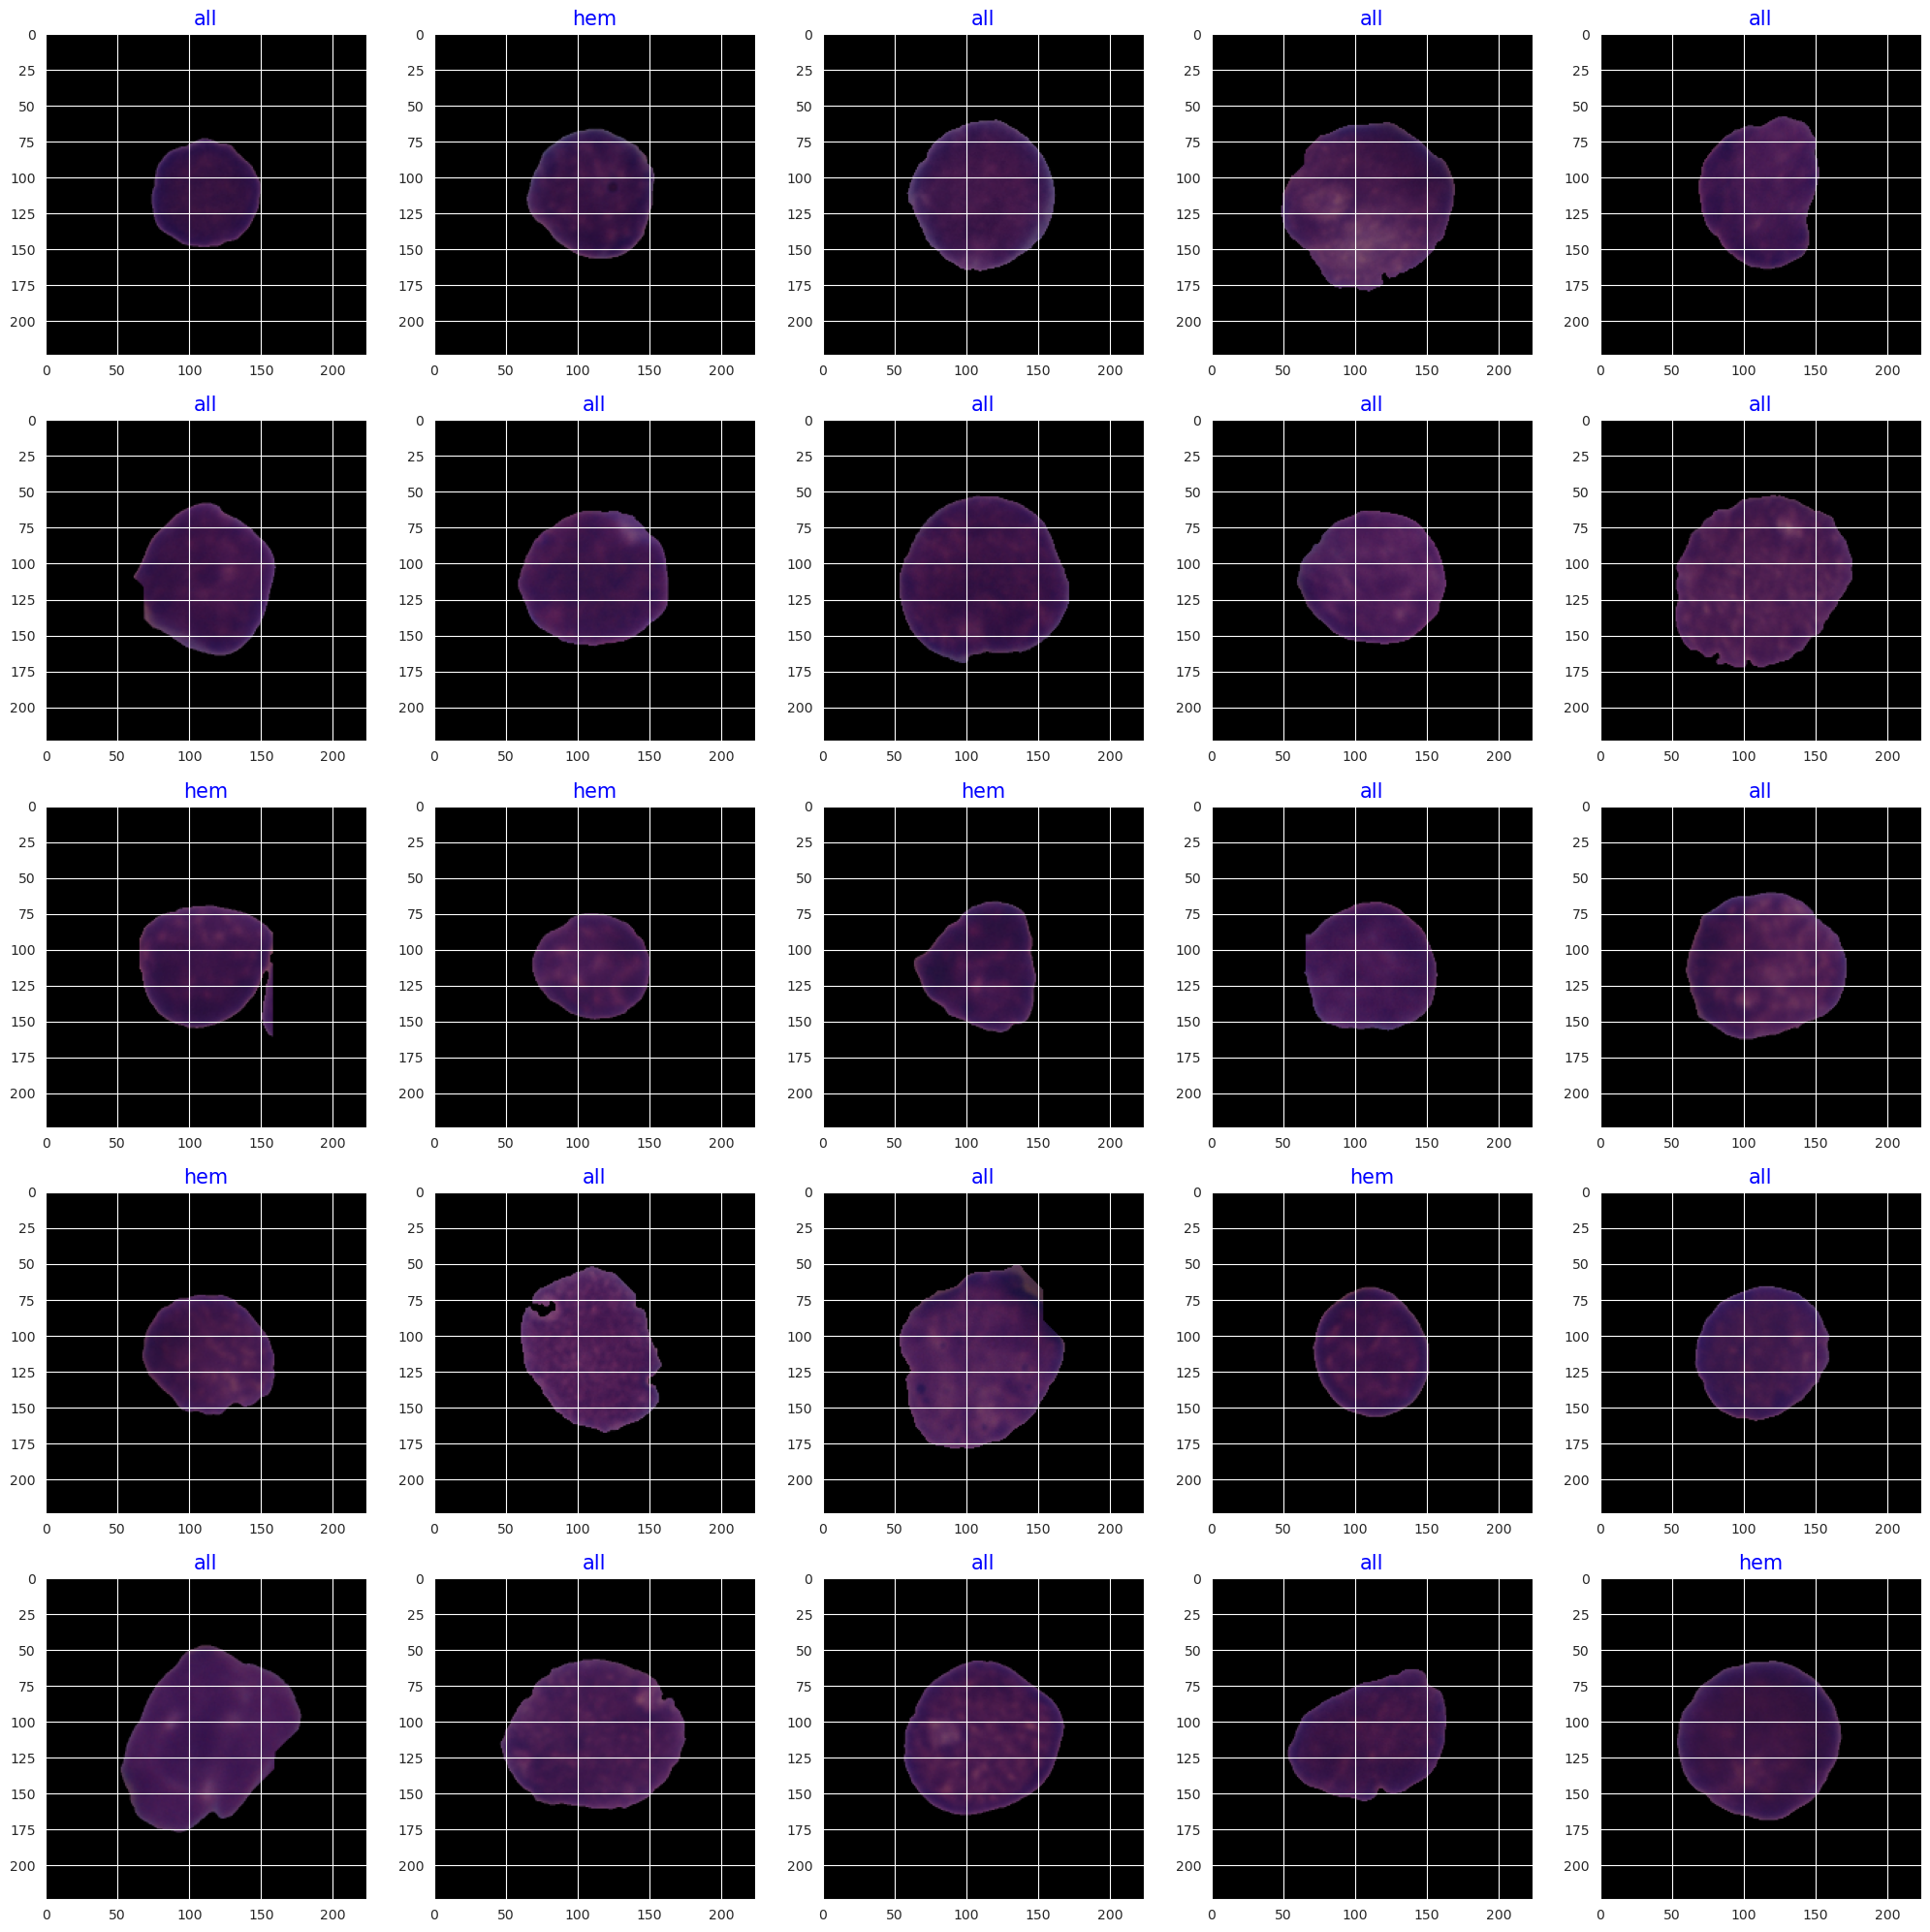

In [10]:
display_imgs(train_gen)

#### **Model Creation**

In [11]:
# create a fundamental model structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# using EfficientNetB3
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 11,183,665
Trainable params: 11,093,290
Non

#### **Set Callback Parameters**

In [23]:
batch_size = 40   
epochs = 40   
patience = 1
stop_patience = 3
threshold = 0.9
factor = 0.5
ask_epoch = 5
batches = int(np.ceil(len(train_gen.labels) / batch_size))  

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

TypeError: __init__() missing 1 required positional argument: 'ask_epoch'

#### **Train model**

In [13]:
trained_model = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Do you want model asks you to halt the training [y/n] ?


 y


 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /40     5.170   82.686   3.96500  69.418   0.00100  0.00100  accuracy     0.00    185.38 
 2 /40     2.482   89.601   1.99224  84.240   0.00100  0.00100  accuracy     8.36    143.14 
 3 /40     1.459   91.155   1.31460  84.615   0.00100  0.00100  val_loss    34.01    142.77 
 4 /40     0.901   93.072   1.04000  80.800   0.00100  0.00100  val_loss    20.89    142.72 
 5 /40     0.584   93.943   0.53907  91.182   0.00100  0.00100  val_loss    48.17    142.75 
enter H to halt training or an integer for number of epochs to run then ask again


 h


training has been halted at epoch 5 due to user input
training elapsed time was 0.0 hours, 22.0 minutes, 3.78 seconds)


#### **Display model performance**

In [14]:
plot_training(trained_model)

AttributeError: 'History' object has no attribute 'trained_model'

# **Evaluate model**

In [15]:
testing_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([testing_length // n for n in range(1, testing_length + 1) if testing_length%n == 0 and testing_length/n <= 80]))
test_steps = testing_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

20/20 [==============================] - 22s 1s/step - loss: 0.5545 - accuracy: 0.9019
Train Loss:  0.47441914677619934
Train Accuracy:  0.9399999976158142
--------------------
Validation Loss:  0.529021143913269
Validation Accuracy:  0.9137499928474426
--------------------
Test Loss:  0.5544674396514893
Test Accuracy:  0.9018750190734863


# **Get Predictions**

In [16]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[0 0 0 ... 0 1 0]


#### **Confusion Matrics and Classification Report**

Confusion Matrix (Without Normalized)
[[1000   91]
 [  66  443]]
              precision    recall  f1-score   support

         all       0.94      0.92      0.93      1091
         hem       0.83      0.87      0.85       509

    accuracy                           0.90      1600
   macro avg       0.88      0.89      0.89      1600
weighted avg       0.90      0.90      0.90      1600



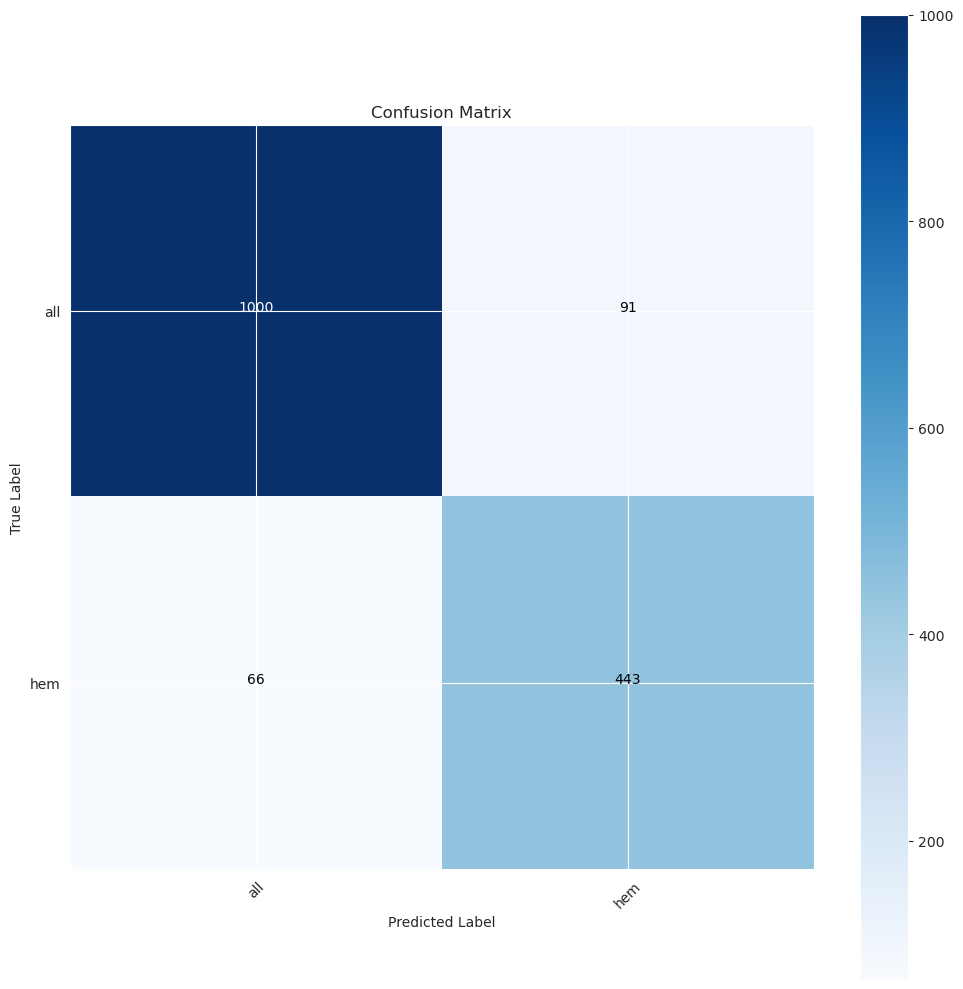

In [17]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

#### **Save model**

In [18]:
model_name = model.input_names[0][:-6]
subject = input('Enter Project Subject')
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

Enter Project Subject leukemia


model was saved as efficientnetb3-leukemia-90.19.h5
weights were saved as efficientnetb3-leukemia-weights.h5


#### **Generate CSV files containing classes indicies & image size**

In [20]:
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

class csv file was saved as leukemia-class_dict.csv


In [ ]:
from joblib import dump
pt = dump(model, 'leukemia.joblib')

In [ ]:
model.save('leukemia.h5')

In [ ]:
!pip install tensorflowjs

In [ ]:
import tensorflowjs as tfjs

model = tf.keras.models.load_model('/kaggle/working/leukemia.h5')

json_model = tfjs.converters.save_keras_model(model, '/kaggle/working/leu.json')

In [ ]:
# import pickle
#ickle.dump(model, open('leukemia.pkl', 'wb'))

In [ ]:
#pt = pickle.load(open('leukemia.pkl', 'rb'))

In [ ]:
#import joblib

# Load the pickle file
#model = joblib.load("leukemia.pkl")


In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
from keras.models import load_model
model = load_model('/kaggle/working/leukemia.h5')

dir_path = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/'

for filename in os.listdir(dir_path):
    if filename.endswith('.bmp'):
        img = cv2.imread(os.path.join(dir_path, filename))
        img = Image.fromarray(img, 'RGB')
        img = img.resize((224, 224))
        img = np.array(img)
        img = np.expand_dims(img, axis=0)
        res = np.argmax(model.predict(img), axis=-1)
        print(filename, ':', res)

In [ ]:
!pip install joblib